### Libraries

In [22]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import torch
import torch.nn.functional as F
from scipy.signal import welch

In [10]:
def lorentzian_function(x, s0, corner):
    return (s0*corner**2) / (x**2 + corner**2)

In [11]:
def multi_fractal_function(x, beta_low, beta_high, A, B, corner):
    return np.where(x < corner, A * x**beta_low, B * x**beta_high)

In [12]:
# Function to visualize the original time series
def visualize_time_series(time_series, sampling_interval, title="Time Series"):
    # Generate time points based on the sampling interval and length of the series
    time_points = [i * sampling_interval for i in range(len(time_series))]
    
    plt.figure(figsize=(8, 5))
    plt.plot(time_points, time_series, label='Time Series', linewidth=1.5, color='green')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal Intensity')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [13]:
# Function to visualize the Power Spectral Density
def visualize_psd(xdata, ydata, title="Power Spectral Density"):
    plt.figure(figsize=(8, 5))
    plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='blue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

In [14]:
# Function for Gaussian smoothing with FWHM input
def gaussian_smoothing_with_fwhm(data, fwhm):
    """
    Apply Gaussian kernel smoothing to a time series with FWHM.

    Parameters:
    - data (numpy array): Input time-series data.
    - fwhm (float): Full-width at half-maximum (FWHM) for the Gaussian kernel.

    Returns:
    - smoothed_data (numpy array): Smoothed time-series data.
    """
    sigma = fwhm / 2.3548  # Convert FWHM to sigma
    smoothed_data = gaussian_filter1d(data, sigma=sigma)
    return smoothed_data

### Plot time series for one ROI across datasets

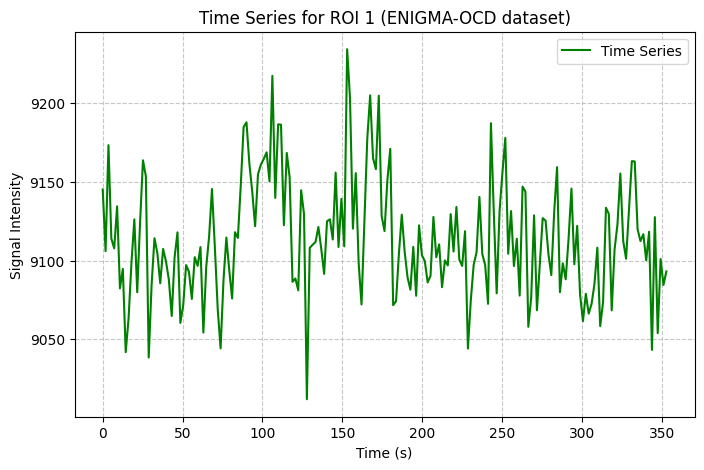

In [31]:
# ENIGMA-OCD
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")
time_series_data = time_series_data.T
time_series_data[0,:].shape

TR = 1.8
visualize_time_series(time_series_data[0,:], TR, title="Time Series for ROI 1 (ENIGMA-OCD dataset)")

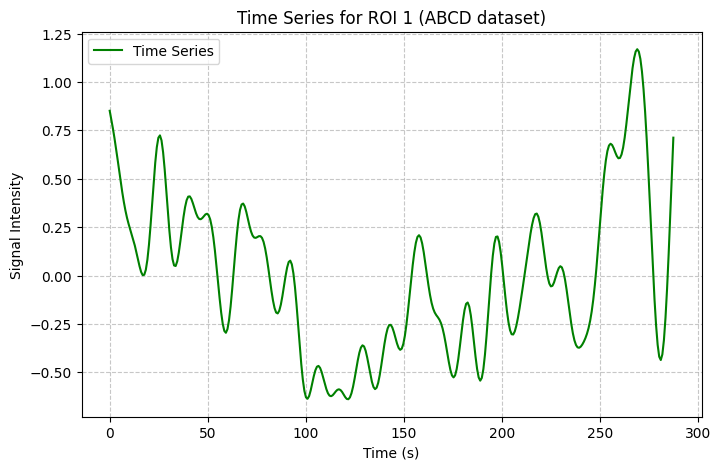

In [32]:
# ABCD
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_sub-NDARINV0A4P0LWM.npy")
time_series_data = time_series_data.T
time_series_data[0,:].shape

TR = 0.8
visualize_time_series(time_series_data[0,:], TR, title="Time Series for ROI 1 (ABCD dataset)")

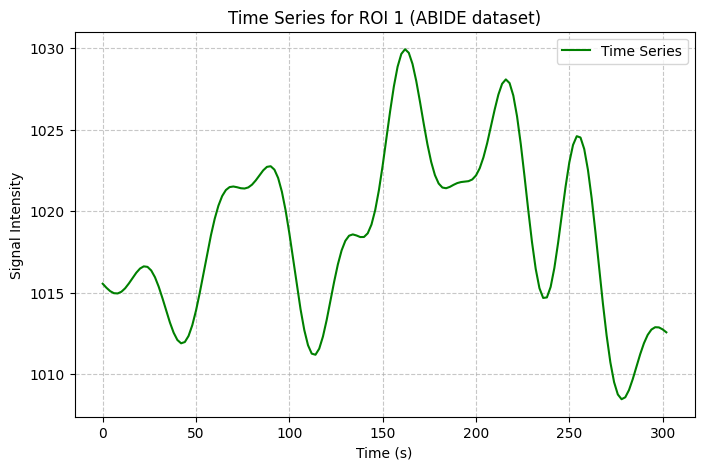

In [33]:
# ABIDE
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_400Parcels_17Networks_28743.npy")
time_series_data = time_series_data.T
time_series_data[0,:].shape

TR = 2
visualize_time_series(time_series_data[0,:], TR, title="Time Series for ROI 1 (ABIDE dataset)")

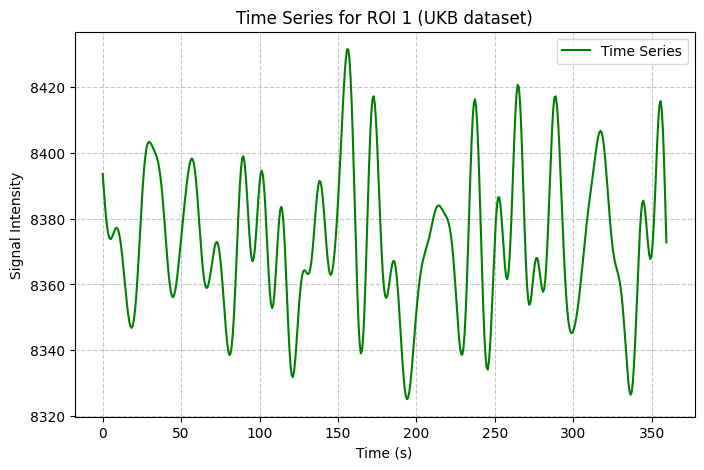

In [34]:
# UKB
time_series_data = np.load("/global/homes/p/pakmasha/ENIGMA-OCD results/Examples from other datasets/schaefer_400Parcels_17Networks_4357334.npy")
time_series_data = time_series_data.T
time_series_data[0,:].shape

TR = 0.735
visualize_time_series(time_series_data[0,:], TR, title="Time Series for ROI 1 (UKB dataset)")

### Compute the knee frequency using smoothed average time series

In [42]:
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")

y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]

TR = 1.8

'''
get knee frequency
'''

sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec   

# Apply Gaussian smoothing
fwhm = 6
smoothed_sample_whole = gaussian_smoothing_with_fwhm(sample_whole, fwhm)

T = TimeSeries(smoothed_sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(smoothed_sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(smoothed_sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

# Save the results
knee_smoothed_avg = knee
f1_smoothed_avg = f1
f2_smoothed_avg = f2

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value: {knee}")
print(f"f1: {f1}")
print(f"f2: {f2}")

frequency_range max: 98
knee value: 8
f1: 0.022712936464810363
f2: 0.16


/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/3665159358.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


In [43]:
T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
S_original1 = SpectralAnalyzer(T1)  # creates a spectral analyzer object for the time-series data T1

use_raw_knee = T

if use_raw_knee:
    FA1 = FilterAnalyzer(T1, lb = f2)  # filters the time-series data T1 by applying a lower bound f2
else:
    FA1 = FilterAnalyzer(T1, lb = S_original1.spectrum_fourier[0][pink])

print(f"before z-score normalization: {FA1.filtered_boxcar.data[0, :10]}")

high = stats.zscore(FA1.filtered_boxcar.data, axis=1) 

print(f"after z-score normalization: {high[0, :10]}")

ultralow_low = FA1.data-FA1.filtered_boxcar.data
    
# 02 low ~ ultralow   # extracts the low and ultralow-frequency components
T2 = TimeSeries(ultralow_low, sampling_interval=TR)  # creates a time-series object from ultralow_low
S_original2 = SpectralAnalyzer(T2)  # creates a spectral analyzer object for the time-series data T2

if use_raw_knee:
    FA2 = FilterAnalyzer(T2, lb=f1)  # filters the time-series data T2 by applying a lower bound f1
else:    
    FA2 = FilterAnalyzer(T2, lb= S_original2.spectrum_fourier[0][knee])

filtering_type = 'Boxcar'

if filtering_type == 'FIR':
    low = stats.zscore(FA2.fir.data, axis=1)
    ultralow = stats.zscore(FA2.data-FA2.fir.data, axis=1)
elif filtering_type == 'Boxcar':
    low = stats.zscore(FA2.filtered_boxcar.data, axis=1)
    ultralow = stats.zscore(FA2.data-FA2.filtered_boxcar.data, axis=1)

before z-score normalization: [9132.9356198  9079.68696869 9142.98446936 9116.48312924 9099.99540771
 9139.39294459 9107.14395218 9139.79860404 9102.55686358 9095.62587373]
after z-score normalization: [ 0.96833194 -1.68133577  1.46836549  0.14965142 -0.67078219  1.28965022
 -0.31506863  1.30983594 -0.54332343 -0.88821142]


### Compute the knee frequency using smoothed original time series

##### Smooth the original time series

Original: [[ 9145.17638384  9105.99220016  9173.30531867  9114.02343587
   9107.7442333 ]
 [11876.1617999  11892.09795426 11909.49505644 11913.53680219
  11887.30409721]
 [ 8794.61133594  8786.1837897   8812.07720084  8819.52548498
   8813.33733239]
 [10539.996906   10480.8387419  10526.53957154 10533.05121727
  10502.35180521]
 [ 9909.67273961  9894.4914222   9916.17713178  9921.15400552
   9909.02612338]]
Smoothed: [[ 9135.64611779  9132.39229481  9140.76070952  9126.83496147
   9116.65442208]
 [11881.41598913 11892.59823183 11904.67965831 11905.07640543
  11895.7773263 ]
 [ 8792.93625576  8795.4957325   8807.22707185  8814.26864566
   8808.0432596 ]
 [10523.9521989  10508.75571829 10517.01414567 10522.00728634
  10512.40381844]
 [ 9905.86896439  9904.39195681  9911.85380589  9916.43372559
   9915.64441585]]


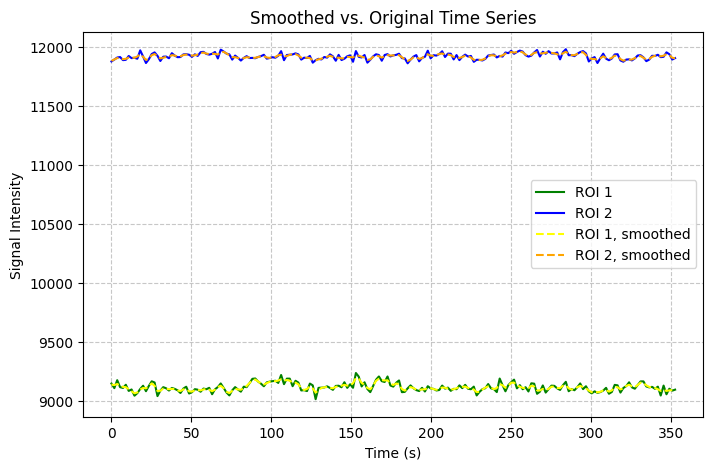

In [51]:
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")

y = time_series_data.T # [180, seq_len]

# Apply Gaussian kernel to each ROI
fwhm = 2
smoothed_y = np.array([gaussian_smoothing_with_fwhm(roi, fwhm) for roi in y])

print(f"Original: {y[:5,:5]}")
print(f"Smoothed: {smoothed_y[:5,:5]}")

TR = 1.8

time_points = [i * TR for i in range(len(y[0,:]))]
title = "Smoothed vs. Original Time Series"
plt.figure(figsize=(8, 5))
plt.plot(time_points, y[0,:], label='ROI 1', linewidth=1.5, color='green')
plt.plot(time_points, y[1,:], label='ROI 2', linewidth=1.5, color='blue')
plt.plot(time_points, smoothed_y[0,:], label='ROI 1, smoothed', linestyle='--', linewidth=1.5, color='yellow')
plt.plot(time_points, smoothed_y[1,:], label='ROI 2, smoothed', linestyle='--', linewidth=1.5, color='orange')
plt.xlabel('Time (s)')
plt.ylabel('Signal Intensity')
plt.title(title)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

##### Calculate knee frequency

In [50]:
# smoothed_y = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002_smoothed_2mm.npy").T
ts_length = smoothed_y.shape[1]
sample_whole = np.zeros(ts_length,)
intermediate_vec = smoothed_y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=smoothed_y[i]

sample_whole /= intermediate_vec   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

# initial parameter
p0 = [0, 0.006]

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000)

f1 = popt[1]

knee = round(popt[1]/(1/(sample_whole.shape[0]*TR)))

if knee <= 0:
    knee = 1

# initial parameter
p1 = [2, 1, 23, 25, 0.16]
# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)
pink = round(popt_mo[-1]/(1/(sample_whole.shape[0]*TR)))
f2 = popt_mo[-1]

print(f"frequency_range max: {xdata.shape[0]}")
print(f"knee value when smoothing original ts: {knee}, knee value when smoothing average ts: {knee_smoothed_avg}")
print(f"f1 when smoothing original ts: {f1}, f1 when smoothing average ts: {f1_smoothed_avg}")
print(f"f2 when smoothing original ts: {f2}, f2 when smoothing average ts: {f2_smoothed_avg}")

frequency_range max: 98
knee value when smoothing original ts: 26, knee value when smoothing average ts: 8
f1 when smoothing original ts: 0.07322128808924844, f1 when smoothing average ts: 0.022712936464810363
f2 when smoothing original ts: 0.16, f2 when smoothing average ts: 0.16


/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/1717584680.py:34: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)


### Save the smoothed time-series data

In [ ]:
# Define the base path where the files are stored
base_path = '/pscratch/sd/p/pakmasha/MBBN_data'

# Choose the kernel size
fwhm = 4

# Walk through all subdirectories and process .npy files
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.npy') and file.split('_')[-2] != "smoothed":
            # Construct full path to the .npy file
            npy_file_path = os.path.join(root, file)

            # Load the .npy file into a pandas DataFrame
            data = np.load(npy_file_path)

            # Apply Gaussian smoothing
            smoothed_data = np.array([gaussian_smoothing_with_fwhm(col, fwhm) for col in data.T]).T

            # if file == "Amsterdam-VUmc_sub-916002.npy":
            #     print(f"Original: {data.T[:5,:5]}")
            #     print(f"Smoothed: {smoothed_data.T[:5,:5]}")

            # Construct the output file name
            smoothed_file_name = f"{os.path.splitext(file)[0]}_smoothed_{fwhm}mm.npy"
            smoothed_file_path = os.path.join(root, smoothed_file_name)

            # Save the smoothed time-series data
            np.save(smoothed_file_path, smoothed_data)

            # Print status
            print(f"Smoothed file saved: {smoothed_file_path}")

Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Barcelona-HCPB_sub-008/Barcelona-HCPB_sub-008_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Brazil_sub-C002061/Brazil_sub-C002061_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb3225/Yale-Pittinger-HCP-Prisma_sub-YaleHCPPrismapb3225_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Seoul-SNU_sub-NOR117CSJ/Seoul-SNU_sub-NOR117CSJ_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Dresden_sub-GEROME3073/Dresden_sub-GEROME3073_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Bergen_sub-00059/Bergen_sub-00059_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-C0181/Bangalore-NIMHANS_sub-C0181_smoothed_4mm.npy
Smoothed file saved: /pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-C0128/Bangalore-NIMHANS_sub-C0128_smoothed_4mm.npy


### Study the padding part

In [18]:
# Define the base path where the .tsv files are stored
base_path = '/pscratch/sd/p/pakmasha/MBBN_data'

# Create a dictionary to store knee values for each site
f1_dict = {}
f2_dict = {}
seq_len_dict = {}
error_count = 0

# Walk through all subdirectories and process .npy files
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.endswith('.npy') and file.split('_')[-2] != 'smoothed':
            # Construct full path to the .tsv file
            npy_file_path = os.path.join(root, file)
            # print(f"npy_file_path: {npy_file_path}")

            # Calculate the repetition time (TR) depending on the site
            site = file.split('_')[-2]
            if 'Amsterdam-AMC' in site:
                TR = 2.375
            elif 'Amsterdam-VUmc' in site:
                TR = 1.8
            elif 'Barcelona-HCPB' in site:
                TR = 2
            elif 'Bergen' in site:
                TR = 1.8
            elif 'Braga-UMinho-Braga-1.5T' in site:
                TR = 2
            elif 'Braga-UMinho-Braga-1.5T-act' in site:
                TR = 2
            elif 'Braga-UMinho-Braga-3T' in site:
                TR = 1
            elif 'Brazil' in site:
                TR = 2
            elif 'Cape-Town-UCT-Allegra' in site:
                TR = 1.6
            elif 'Cape-Town-UCT-Skyra' in site:
                TR = 1.73
            elif 'Chiba-CHB' in site:
                TR = 2.3
            elif 'Chiba-CHBC' in site:
                TR = 2.3 
            elif 'Chiba-CHBSRPB' in site:
                TR = 2.5 
            elif 'Dresden' in site:
                TR = 0.8 
            elif 'Kyoto-KPU-Kyoto1.5T' in site:
                TR = 2.411 
            elif 'Kyoto-KPU-Kyoto3T' in site:
                TR = 2
            elif 'Kyushu' in site:
                TR = 2.5
            elif 'Milan-HSR' in site:
                TR = 2
            elif 'New-York' in site:
                TR = 1
            elif 'NYSPI-Columbia-Adults' in site:
                TR = 0.85
            elif 'NYSPI-Columbia-Pediatric' in site:
                TR = 0.85
            elif 'Yale-Pittinger-HCP-Prisma' in site:
                TR = 0.8
            elif 'Yale-Pittinger-HCP-Trio' in site:
                TR = 0.7
            elif 'Yale-Pittinger-Yale-2014' in site:
                TR = 2
            elif 'Bangalore-NIMHANS' in site:
                TR = 2 
            elif 'Barcelone-Bellvitge-ANTIGA-1.5T' in site:
                TR = 2
            elif 'Barcelone-Bellvitge-COMPULSE-3T' in site:
                TR = 2
            elif 'Barcelone-Bellvitge-PROV-1.5T' in site:
                TR = 2
            elif 'Barcelone-Bellvitge-RESP-CBT-3T' in site:
                TR = 2
            elif 'Seoul-SNU' in site:
                TR = 3.5
            elif 'Shanghai-SMCH' in site:
                TR = 3
            elif 'UCLA' in site:
                TR = 2
            elif 'Vancouver-BCCHR' in site:
                TR = 2
            elif 'Yale-Gruner' in site:
                TR = 2
            else:
                raise ValueError(f"Site '{site}' does not have a defined TR value in TR_mappings. Please add it.")

            # Load the .npy file and calculate knee frequencies
            sequence_length = 148
            y = np.load(npy_file_path)[20:20+sequence_length].T   
            # print(f"y: {y}")
            # print(f"y.shape: {y.shape}")

            ts_length = y.shape[1]   # temporal padding
            # print(f"ts_length: {ts_length}")
            pad = sequence_length-ts_length
            # print(f"pad: {pad}")

            try: 
                sample_whole = np.zeros(sequence_length,) # originally sequence_length   ## aggregates time-series data across ROIs   # sample_whole.shape = # of timepoints,

                ##### DEBUG STATEMENT #####
                # sample_whole = np.zeros(sequence_length - 20,)
                # print(f"sample_whole.shape: {sample_whole.shape}")
                ###########################

                intermediate_vec = y.shape[0]

                for i in range(intermediate_vec):
                    # print(f"y[i] shape: {y[i].shape}")
                    sample_whole+=y[i]

                sample_whole /= intermediate_vec    # averages the time-series signals (y) across a set number of ROIs

                # Smooth the averaged time series
                fwhm = 2
                smoothed_sample_whole = gaussian_smoothing_with_fwhm(sample_whole, fwhm)

                T = TimeSeries(smoothed_sample_whole, sampling_interval=TR)  # computes power spectral density (PSD) of the averaged time-series signal
                S_original = SpectralAnalyzer(T)

                # Lorentzian function fitting (dividing ultralow ~ low)  ## extracts the PSD data
                xdata = np.array(S_original.spectrum_fourier[0][1:])  # xdata = frequency values  
                ydata = np.abs(S_original.spectrum_fourier[1][1:])    # ydata = corresponding power values
                # print(f"xdata.shape: {xdata.shape}")
                # print(f"ydata.shape: {ydata.shape}")

                # initial parameter setting
                p0 = [0, 0.006]   
                param_bounds = ([-np.inf, 0], [np.inf, 1])

                # fitting Lorentzian function
                popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000, bounds=param_bounds)   # popt = optimal parameters

                f1 = popt[1]

                knee = round(popt[1]/(1/(smoothed_sample_whole.shape[0]*TR)))   # calculates knee frequency 
                # print(f"knee: {knee}")

                if knee <= 0:
                    knee = 1

                if knee > ydata.shape[0]:
                    print(f"knee value: {knee}")
                    print(f"ydata.shape: {ydata.shape}")

                # divide low ~ high
                # initial parameter setting
                p1 = [2, 1, 23, 25, 0.16]
            
                # fitting multifractal function
                popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)   # fits a multi-fractal model to the high-frequency range (above the knee)
                pink = round(popt_mo[-1]/(1/(smoothed_sample_whole.shape[0]*TR)))   # pink = an additional boundary
                f2 = popt_mo[-1]

                # Save values to the dictionaries
                # Check if the key exists in the dictionary
                if site in f1_dict:
                    # Append the value to the existing list
                    f1_dict[site].append(f1)
                    f2_dict[site].append(f2)
                    seq_len_dict[site].append(sequence_length)
                else:
                    # Create the key and initialize it with a list containing the value
                    f1_dict[site] = [f1]
                    f2_dict[site] = [f2]   
                    seq_len_dict[site] = [sequence_length] 
                # print(f"Successfully processed {file}")  

                T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
                S_original1 = SpectralAnalyzer(T1)  # creates a spectral analyzer object for the time-series data T1

                use_raw_knee = T

                if use_raw_knee:
                    FA1 = FilterAnalyzer(T1, lb = f2)  # filters the time-series data T1 by applying a lower bound f2
                else:
                    FA1 = FilterAnalyzer(T1, lb = S_original1.spectrum_fourier[0][pink])

                high = stats.zscore(FA1.filtered_boxcar.data, axis=1) 
                ultralow_low = FA1.data-FA1.filtered_boxcar.data
                    
                # 02 low ~ ultralow   # extracts the low and ultralow-frequency components
                T2 = TimeSeries(ultralow_low, sampling_interval=TR)  # creates a time-series object from ultralow_low
                S_original2 = SpectralAnalyzer(T2)  # creates a spectral analyzer object for the time-series data T2

                if use_raw_knee:
                    FA2 = FilterAnalyzer(T2, lb=f1)  # filters the time-series data T2 by applying a lower bound f1
                else:    
                    FA2 = FilterAnalyzer(T2, lb= S_original2.spectrum_fourier[0][knee])

                filtering_type = 'Boxcar'

                if filtering_type == 'FIR':
                    low = stats.zscore(FA2.fir.data, axis=1)
                    ultralow = stats.zscore(FA2.data-FA2.fir.data, axis=1)
                elif filtering_type == 'Boxcar':
                    low = stats.zscore(FA2.filtered_boxcar.data, axis=1)
                    ultralow = stats.zscore(FA2.data-FA2.filtered_boxcar.data, axis=1)

                print(f"high.shape before padding: {high.shape}")
                print(f"low.shape before padding: {low.shape}")
                print(f"ultralow.shape before padding: {ultralow.shape}")

                # DO PADDING ALWAYS
                high = F.pad(torch.from_numpy(high), (pad//2, pad//2), "constant", 0).T.float()
                low = F.pad(torch.from_numpy(low), (pad//2, pad//2), "constant", 0).T.float()
                ultralow = F.pad(torch.from_numpy(ultralow), (pad//2, pad//2), "constant", 0).T.float()

                print(f"high.shape after padding: {high.shape}")
                print(f"low.shape after padding: {low.shape}")
                print(f"ultralow.shape after padding: {ultralow.shape}")               

            except Exception as e:
                # print(f"Error processing: {file}")
                # print(e)
                error_count += 1
                continue  # Skip the subject if an error occurs
            
# print(f"Knee frequencies f1: {f1_dict}")
# print(f"\nKnee frequencies f2: {f2_dict}")
# print(f"Sequence lengths: {seq_len_dict}")
# print(f"Error processing {error_count} files")

/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/3496182923.py:155: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)   # fits a multi-fractal model to the high-frequency range (above the knee)


high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: (320, 148)
ultralow.shape before padding: (320, 148)
high.shape before padding: (320, 148)
low.shape before padding: 

KeyboardInterrupt: 

### Filtering effect

##### Real example

pad: 0
f1: 0.017650428623710836, f2: 0.16


/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in power
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/1867528834.py:2: RuntimeWarning: overflow encountered in multiply
  return np.where(x < corner, A * x**beta_low, B * x**beta_high)
/tmp/ipykernel_481814/2058624653.py:55: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)   # fits a multi-fractal model to the high-frequency range (above the knee)
/tmp/ipykernel_481814/2058624653.py:93: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  frequencies, psd_before = welch(T2.data, fs=1/T2.sampling_interval)
/global/homes/p/pakmasha/myenv/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 148, using

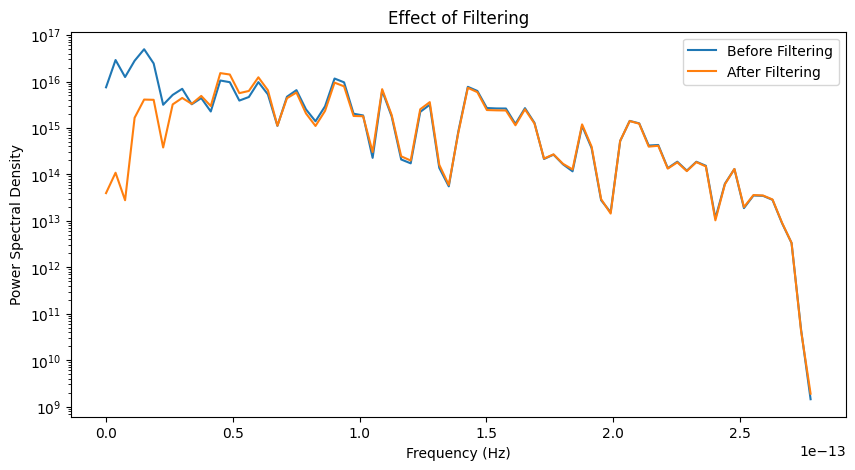

In [33]:
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")
TR = 1.8

sequence_length = 148
y = time_series_data[20:20+sequence_length].T   
ts_length = y.shape[1]  
pad = sequence_length-ts_length
print(f"pad: {pad}")

sample_whole = np.zeros(sequence_length,) # originally sequence_length   ## aggregates time-series data across ROIs   # sample_whole.shape = # of timepoints,
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec    # averages the time-series signals (y) across a set number of ROIs

# Smooth the averaged time series
fwhm = 6
smoothed_sample_whole = gaussian_smoothing_with_fwhm(sample_whole, fwhm)

T = TimeSeries(smoothed_sample_whole, sampling_interval=TR)  # computes power spectral density (PSD) of the averaged time-series signal
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting (dividing ultralow ~ low)  ## extracts the PSD data
xdata = np.array(S_original.spectrum_fourier[0][1:])  # xdata = frequency values  
ydata = np.abs(S_original.spectrum_fourier[1][1:])    # ydata = corresponding power values
# print(f"xdata.shape: {xdata.shape}")
# print(f"ydata.shape: {ydata.shape}")

# initial parameter setting
p0 = [0, 0.006]   
param_bounds = ([-np.inf, 0], [np.inf, 1])

# fitting Lorentzian function
popt, pcov = curve_fit(lorentzian_function, xdata, ydata, p0=p0, maxfev = 5000, bounds=param_bounds)   # popt = optimal parameters

f1 = popt[1]

knee = round(popt[1]/(1/(smoothed_sample_whole.shape[0]*TR)))   # calculates knee frequency 
# print(f"knee: {knee}")

if knee <= 0:
    knee = 1

if knee > ydata.shape[0]:
    print(f"knee value: {knee}")
    print(f"ydata.shape: {ydata.shape}")

# divide low ~ high
# initial parameter setting
p1 = [2, 1, 23, 25, 0.16]

# fitting multifractal function
popt_mo, pcov = curve_fit(multi_fractal_function, xdata[knee:], ydata[knee:], p0=p1, maxfev = 50000)   # fits a multi-fractal model to the high-frequency range (above the knee)
pink = round(popt_mo[-1]/(1/(smoothed_sample_whole.shape[0]*TR)))   # pink = an additional boundary
f2 = popt_mo[-1]

print(f"f1: {f1}, f2: {f2}")

T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
S_original1 = SpectralAnalyzer(T1)  # creates a spectral analyzer object for the time-series data T1

use_raw_knee = T

if use_raw_knee:
    FA1 = FilterAnalyzer(T1, lb = f2)  # filters the time-series data T1 by applying a lower bound f2
else:
    FA1 = FilterAnalyzer(T1, lb = S_original1.spectrum_fourier[0][pink])

high = stats.zscore(FA1.filtered_boxcar.data, axis=1) 
ultralow_low = FA1.data-FA1.filtered_boxcar.data
    
# 02 low ~ ultralow   # extracts the low and ultralow-frequency components
T2 = TimeSeries(ultralow_low, sampling_interval=TR)  # creates a time-series object from ultralow_low
S_original2 = SpectralAnalyzer(T2)  # creates a spectral analyzer object for the time-series data T2

if use_raw_knee:
    FA2 = FilterAnalyzer(T2, lb=f1)  # filters the time-series data T2 by applying a lower bound f1
else:    
    FA2 = FilterAnalyzer(T2, lb= S_original2.spectrum_fourier[0][knee])

filtering_type = 'Boxcar'

if filtering_type == 'FIR':
    low = stats.zscore(FA2.fir.data, axis=1)
    ultralow = stats.zscore(FA2.data-FA2.fir.data, axis=1)
elif filtering_type == 'Boxcar':
    low = stats.zscore(FA2.filtered_boxcar.data, axis=1)
    ultralow = stats.zscore(FA2.data-FA2.filtered_boxcar.data, axis=1)             

# Compute PSD before filtering
frequencies, psd_before = welch(T2.data, fs=1/T2.sampling_interval)

# Compute PSD after filtering
frequencies, psd_after = welch(FA2.filtered_boxcar.data, fs=1/T2.sampling_interval)

# Plot the PSD
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, psd_before[0,:], label="Before Filtering")
plt.semilogy(frequencies, psd_after[0,:], label="After Filtering")
# plt.axvline(x=f1, color='red', linestyle='--', label=f'Boundary f1: {f1}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title("Effect of Filtering")
plt.show()


##### Toy example

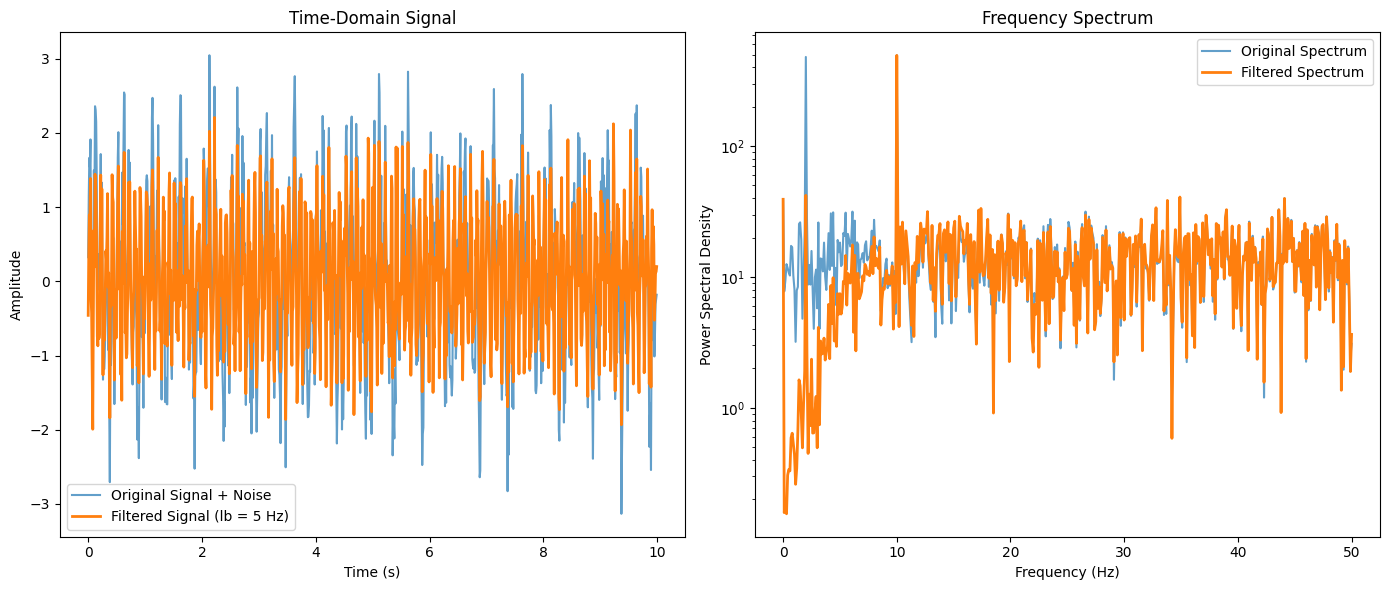

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from nitime.analysis import FilterAnalyzer, SpectralAnalyzer
from nitime.timeseries import TimeSeries

# Step 1: Create a synthetic time-series signal
# Parameters
sampling_interval = 0.01  # Time between samples (100 Hz sampling rate)
timepoints = np.arange(0, 10, sampling_interval)  # 10 seconds of data
TR = sampling_interval

# Signal components
signal = np.sin(2 * np.pi * 2 * timepoints) + np.sin(2 * np.pi * 10 * timepoints)  # 2 Hz and 10 Hz components
noise = 0.5 * np.random.randn(len(timepoints))  # Add Gaussian noise

# Combine signal and noise
y = signal + noise

# Step 2: Create a TimeSeries object
T1 = TimeSeries(y, sampling_interval=TR)

# Step 3: Analyze the frequency spectrum before filtering
S_original = SpectralAnalyzer(T1)

# Step 4: Apply FilterAnalyzer with a lower bound (e.g., 5 Hz)
use_raw_knee = True
f2 = 5  # Lower bound for filtering in Hz
if use_raw_knee:
    FA1 = FilterAnalyzer(T1, lb=f2)
else:
    FA1 = FilterAnalyzer(T1, lb=S_original.spectrum_fourier[0][10])  # Example using another frequency as lower bound

# Step 5: Extract filtered data
filtered_signal = FA1.filtered_boxcar.data  # Extract filtered data

# Step 6: Visualize results
plt.figure(figsize=(14, 6))

# Plot time-domain signals
plt.subplot(1, 2, 1)
plt.plot(timepoints, y, label="Original Signal + Noise", alpha=0.7)
plt.plot(timepoints, filtered_signal, label=f"Filtered Signal (lb = {f2} Hz)", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Time-Domain Signal")

# Plot frequency spectrum
frequencies, psd_original = S_original.spectrum_fourier
frequencies_filtered, psd_filtered = SpectralAnalyzer(TimeSeries(filtered_signal, sampling_interval=TR)).spectrum_fourier

plt.subplot(1, 2, 2)
plt.semilogy(frequencies, np.abs(psd_original), label="Original Spectrum", alpha=0.7)
plt.semilogy(frequencies_filtered, np.abs(psd_filtered), label="Filtered Spectrum", linewidth=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend()
plt.title("Frequency Spectrum")

plt.tight_layout()
plt.show()
